# 03) Improve labels

A key problem with the headlines data is that it was collected by scrapping online news sources, keyword matching and then feeding the keyword matches to Google Gemini for labelling. But the keyword matching process likely missed many non-risk headlines, meaning the default non-risk category likely contains false negatives. 

To tackle this mislabeled data problem, a regression model for each language (Spanish and Portuguese) is trained on half of the data at a time to generate predictions for the other half's non-risk headlines. A percentage of low probability headlines from each half is kept, eliminating many false negatives while at the same time tackling the class imbalance problem (see notebook 1). 

## Read-in data

Seperate dataframes are created for each language (Spanish & Portuguese). 

In [2]:
import pandas as pd
import numpy as np

# read-in data
df = pd.read_csv('../Data/original_headlines.csv', encoding='utf-8')
print(str(round(len(df)/1000, 1)) + 'K Total headlines')

# include only spanish 
spanish_df = df[df.country.isin(['Argentina', 'Colombia', 'Mexico'])].reset_index(drop=True)
print(str(round(len(spanish_df)/1000, 1)) + 'K Spanish headlines')

# include only portuguese 
portuguese_df = df[df.country == 'Brazil'].reset_index(drop=True)
print(str(round(len(portuguese_df)/1000, 1)) + 'K Portuguese headlines')

85.8K Total headlines
69.3K Spanish headlines
13.9K Portuguese headlines


## Remove duplicates & thumbnails

Headlines containing the word thumbnail are normally videos which cannot be scraped. Many of these with a similar format in the non-risk headlines data add little value in terms of variety and therefore are removed.

In [3]:
# remove duplicates
spanish_df.drop_duplicates(subset='headline', inplace=True)
portuguese_df.drop_duplicates(subset='headline', inplace=True)

# remove thumbnails
spanish_df = spanish_df[~spanish_df['headline'].str.lower().str.contains('thumbnail', na=False)]
portuguese_df = portuguese_df[~portuguese_df['headline'].str.lower().str.contains('thumbnail', na=False)]

# removes english headlines from the spanish dataset
spanish_df = spanish_df.loc[~spanish_df.website.isin(['Colombia Reports'])]

# reset index
spanish_df.reset_index(drop=True, inplace=True)
portuguese_df.reset_index(drop=True, inplace=True)

## Clean text

The text is subjected to common cleaning techniques to reduce dimensionality.

In [4]:
import string
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
spanish_stop_words = set(stopwords.words('Spanish'))
portuguese_stop_words = set(stopwords.words('Portuguese'))

# common text cleaning techniques
def clean_text(text, language):
    text = text.strip()
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + '¡¿'))

    if language=='Spanish':
        text = ' '.join([word for word in text.split() if word not in spanish_stop_words])
    elif language=='Portuguese':
        text = ' '.join([word for word in text.split() if word not in portuguese_stop_words])
    
    return text

spanish_df['headline'] = [clean_text(x, 'Spanish') for x in spanish_df['headline']]
portuguese_df['headline'] = [clean_text(x, 'Portuguese') for x in portuguese_df['headline']]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jack-\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Put aside data

A random percentage of the data from each dataframe is put aside. It is useful to this now because if not we may end up evaluating on an artificially easy dataset in which most of the more difficult edge cases for non-risk headlines have been removed. 

In [5]:
import random 

# returns the main dataframe and a random sample to be put aside for evaluation
def put_aside_random_percent(df, percent):
    indices = list(df.index)
    dividor = int(100 / percent)
    sample_size = int(np.floor(len(indices)/dividor))
    random_sample = random.sample(indices, sample_size)
    put_aside_headlines = df.iloc[random_sample,:].reset_index(drop=True)
    df = df.loc[~df.index.isin(random_sample)].reset_index(drop=True)
    return df, put_aside_headlines

spanish_df_post_sample, spanish_put_aside_df = put_aside_random_percent(spanish_df, 10)
portuguese_df_post_sample, portuguese_put_aside_df = put_aside_random_percent(portuguese_df, 10)

## Split dataframe

Each dataframe is randomly split into two sets so a model can be trained on each set and used to predict headlines for the other.

In [6]:
# randomly split a dataframe into 2 equal size groups 
def split_dataframes(df):
    population = list(range(len(df)))
    half_headlines = int(np.floor(len(population) / 2))
    random_samples = random.sample(population, half_headlines)
    return df.loc[random_samples,:].reset_index(drop=True), df.loc[~df.index.isin(random_samples), :].reset_index(drop=True)

## Fit model

A model is fit using TF-IDF vectors and logistic regression. A regression model is used to obtain probabilities so that the classification threshold can be easily varied. 

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# vectorizes data and fits a model 
def fit_model(df):
    X, y = df.headline, [int(pd.notna(x)) for x in df.risk_type]
    vectorizer = TfidfVectorizer()
    train_tfidf = vectorizer.fit_transform(X)
    model = LogisticRegression()
    model.fit(train_tfidf, y)
    return vectorizer, model

## Generate predictions

Predictions from one half of each dataset are added to the other half.

In [8]:
# returns predictions as binary decisions and probabilities
def predict_headlines(df, vectorizer, model):
    tfidf_vectors = vectorizer.transform(df.headline)
    y_preds = model.predict(tfidf_vectors)
    y_pred_prob = [np.mean(model.predict_proba(x)[:, 1]) for x in tfidf_vectors]
    return y_preds, y_pred_prob

# adds the predictions for each half of the data to their respective dfs
def add_predictions_to_df(primary_df, secondary_df):
    vectorizer, model = fit_model(secondary_df)
    y_preds, y_pred_prob = predict_headlines(primary_df, vectorizer, model)
    primary_df['y_pred'], primary_df['y_pred_prob'] = y_preds, y_pred_prob
    primary_df.sort_values('y_pred_prob', ascending=False, inplace=True)
    return primary_df

# returns a headlines dataframe along with their predictions for veiwing
# this is useful so we can set appropriate upper and lower limits for the 
# slice of low probability non-risk headlines we will select later on
def view_headline_preds(df, language):
    df_1, df_2 = split_dataframes(df) 
    df_1, df_2 = add_predictions_to_df(df_1, df_2), add_predictions_to_df(df_2, df_1)
    #df_1, df_2 =  drop_non_risk_headlines(df_1, language), drop_non_risk_headlines(df_2, language)
    return df_1, df_2

spanish_df_1, spanish_df_2 = view_headline_preds(spanish_df_post_sample, 'Spanish')
portuguese_df_1, portuguese_df_2 = view_headline_preds(portuguese_df_post_sample, 'Portuguese')

## Find false negatives threshold

The threshold at which false negatives are no longer common is located and used for the upper limits in the next step.

In [31]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
def view_nonrisk_highest_rows(df, start, end):
    temp_df = df.loc[pd.isna(df.risk_type)].sort_values('y_pred_prob')
    print()
    print('Non-risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent
    
spanish_false_negative_percent = view_nonrisk_highest_rows(spanish_df_1, 7990, 8000)
portuguese_false_negative_percent = view_nonrisk_highest_rows(portuguese_df_1, 1990, 2000)


Non-risk headlines: 23842

13314:   christian nodal pidió matrimonio cantante santandereana
1285:   espaldarazo proyectos cooperación internacional cancillería república alcaldía palmira
23182:   tecnologías cisnes rinocerontes dragones cinco etapas duelo inteligencia artificial
4070:   tras 2 días universidad javeriana pronunció muerte médica dejó dura carta
24421:   atentado cristina kirchner
16840:   atentado cristina kirchner
1558:   falleció laura gómez joven arrollada junto amiga caravana motociclistas
2748:   murió estadounidense medellín hombre cayó tercer piso hotel
16518:   permiso trabajo posgraduado canadá cómo aplicar
19028:   emiten nueva alerta zonda zonas mendoza alcanza

Non-risk headlines: 4590

470:   filhote onça resgatado após abandonado casa área rural goiás
5570:   caso apuraçãoao vivo ossada humana achada documento mulher ilha piúma restos mortais encontrados tarde segundafeira 1° região conhecida ilha gambá
4648:   céu caminho drones têm multifunções agronegóc

## Drop false negatives

All non-risk headlines above the threshold above are dropped, eliminating many false negatives and tackling the class imbalance problem (see notebook 1).

In [162]:
# drops a number of non-risk headlines based on their prediction scores
def drop_non_risk_headlines(df, percent):   
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    risk_df = df.loc[~pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(non_risk_df) * percent))
    low_score_non_risk = non_risk_df.iloc[(len(non_risk_df)-upper_limit):(len(non_risk_df)-lower_limit),:]
    return pd.concat([risk_df, low_score_non_risk])

# creates a filtered dataframe combining both halfs of the data 
# after dropping headlines with high predictions
def create_filtered_df(df_1, df_2, percent):
    df_1, df_2 =  drop_non_risk_headlines(df_1, percent), drop_non_risk_headlines(df_2, percent)
    return pd.concat([df_1, df_2])

false_negatives_filtered_spanish_df = create_filtered_df(spanish_df_1, spanish_df_2, spanish_false_negative_percent)
false_negatives_filtered_portuguese_df = create_filtered_df(portuguese_df_1, portuguese_df_2, portuguese_false_negative_percent)

## Find false positives threshold

In [169]:
# this function shows the risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false positives in the data...
def view_risk_lowest_rows(df, start, end):
    temp_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob').reset_index(drop=True)
    print()
    print('Risk headlines: ' + str(len(temp_df)))
    print()
    selected_index_df = temp_df.iloc[start:end, :]
    for i in range(len(selected_index_df)):
        print(str(selected_index_df.index[i]) + ':   ' + selected_index_df.headline.values[i])
    percent = end / len(temp_df)
    return percent
    
spanish_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_spanish_df, 50, 60)
portuguese_false_positive_percent = view_risk_lowest_rows(false_negatives_filtered_portuguese_df, 30, 40)


Risk headlines: 7308

50:   20 hectáreas reserva forestal villa leyva consumieron incendio forestal
51:   mujer denunció ser drogada plataforma transporte bucaramanga historia
52:   parquímetro van 130 mil descargas blinkay parquímetros durango
53:   avanza reglamento tránsito durango capital regidorael 15 noviembre 2023 entregó propuesta nuevo reglamento tránsito vialidad municipal comisión encargada cabildo fecha avanzado en…
54:   platense buscado atraparon españa tras ser condenado abusar hijastra
55:   sufre descarga eléctrica cae 5 metros altura tzucacab
56:   misión descentralización informe final ratifica necesidad reformar regalías
57:   harakiri ecopetrol cómo decisiones impactarían patrimonio público
58:   perdió amparo empresa gasoducto
59:   ‘vi cómo murió señor’ habla víctimas accidente metrocable medellín

Risk headlines: 2715

30:   dois militares civil morrem conflitos linhas trem rio 2h agência brasil
31:   abdo filho abdo filho exportação café conilon segue forte av

## Drop false positives

In [185]:
# drops a number of risk headlines based on their prediction scores
def drop_risk_headlines(df, percent):   
    risk_df = df.loc[~pd.isna(df.risk_type)].sort_values('y_pred_prob')
    non_risk_df = df.loc[pd.isna(df.risk_type)]
    lower_limit, upper_limit = 0, int(np.floor(len(risk_df) * percent))
    high_score_risk = risk_df.iloc[upper_limit:len(risk_df),:]
    combined_df = pd.concat([high_score_risk, non_risk_df])
    return combined_df.reset_index(drop=True)

false_positives_filtered_spanish_df = drop_risk_headlines(false_negatives_filtered_spanish_df, spanish_false_positive_percent)
false_positives_filtered_portuguese_df = drop_risk_headlines(false_negatives_filtered_portuguese_df, portuguese_false_positive_percent)

## Train test split

Creates a train test split for a given dataframe.

In [186]:
from sklearn.model_selection import train_test_split

# returns a train test split
def split_data(df, test_size=0.25):
    X = df.headline
    y = [int(pd.notna(x)) for x in df.risk_type]
    return train_test_split(X, y, test_size=test_size, stratify=y)

## Evaluate model

Prints the accuracy and classification report for a given model on a given set of headlines.

In [187]:
from sklearn.metrics import classification_report, accuracy_score

# evaluates the model's performance and prints the results
def evaluate_model(model, X_test_tfidf, y_test):
    y_pred = model.predict(X_test_tfidf)
    y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1] 
    classification_report_ = classification_report(y_test, y_pred)
    print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
    print("Classification Report:\n", classification_report_)
    print()
    return classification_report_

## Check results

Trains a model on a refined dataset and evaluates it on set aside data. As we can see, the recall for risk headlines (the main business objective of this project) has improved dramatically for both languages compared to that of notebook 2. 

In [188]:
# evaluates a filtered dataset against new headlines
def check_results(train_df, put_aside_df, language):
    print()
    print('*** ' + language + ' ***')
    print()

    X_train, X_test, y_train, y_test = split_data(train_df, test_size=0.01)
    
    vectorizer = TfidfVectorizer()
    X_train_tfidf = vectorizer.fit_transform(X_train)
    
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    print(str(round(len(put_aside_df)/1000, 2)) + 'K put aside headlines')
    
    X_test_tfidf = vectorizer.transform(put_aside_df.headline)
    y_test = [int(pd.notna(x)) for x in put_aside_df.risk_type]
    
    return evaluate_model(model, X_test_tfidf, y_test)

check_results(false_positives_filtered_spanish_df, spanish_put_aside_df, language='Spanish')
check_results(false_positives_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

6.11K put aside headlines
Accuracy: 0.834
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.89      5260
           1       0.45      0.89      0.60       849

    accuracy                           0.83      6109
   macro avg       0.71      0.86      0.75      6109
weighted avg       0.91      0.83      0.85      6109



*** Portuguese ***

1.32K put aside headlines
Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.84      1034
           1       0.50      0.85      0.63       289

    accuracy                           0.78      1323
   macro avg       0.72      0.81      0.74      1323
weighted avg       0.85      0.78      0.80      1323




## Repeat the process...

Given that the process above improved the model, it stands to reason that repeating the false negative filtering process with predictions based on the newly refined dataset could improve the model even further. The results below show that although the overall accuracy for both models declined (likely because we are dropping badly needed data), the most important metric from a business perspective (risk headlines recall) went up in both datasets. 

### Generate new predictions

In [193]:
# resets the indices
false_positives_filtered_spanish_df.reset_index(drop=True, inplace=True)
false_positives_filtered_portuguese_df.reset_index(drop=True, inplace=True)

# creates additional dataframes with new predictions based on a model trained on the newly filtered dataframe
spanish_df_3, spanish_df_4 = view_headline_preds(false_positives_filtered_spanish_df, 'Spanish')
portuguese_df_3, portuguese_df_4 = view_headline_preds(false_positives_filtered_portuguese_df, 'Portuguese')

### Find new false negatives threshold

In [194]:
# this function shows the non-risk labelled headlines ordered
# from the lowest to highest probability score. An ml practitioner 
# can use this to find the appropriate threshold for which 
# there are no longer many false negatives in the data...
new_spanish_percent = view_nonrisk_highest_rows(spanish_df_4, 7001, 7011)
new_portuguese_percent = view_nonrisk_highest_rows(portuguese_df_4, 1681, 1691)


Non-risk headlines: 8064

5673:   francia clasifica cuartos
4528:   extranjeros usado cédulas documentos falsos poder ir ejemplo unidos situación quiere controlar biome
8366:   fechas reapertura carriles exprés
9371:   comunicadora confesó casa vivieron hechos violentos protagonizó padre aunque paso tiempo aprendió perdonarlo
3896:   proyectil provenido caso fallido sicariato presentó pocas cuadras zona falleció uniformado
4903:   megaoperativo 200 policías villa san antonio allanamientos detenciones
7885:   acepta poseer ‘terreno caliente’ explica cómo consiguió
3643:   vinculan elementos gn muerte niña 9 años slp
9492:   ciudadanos venezolanos permisos protección temporal podrán abrir cuenta billetera digital
3784:   lujos repentinos ponen tela juicio hermano laura sarabia

Non-risk headlines: 2015

1347:   10 vote agora troféu correio folia junina vote melhor música joão 2024
2541:   equipe entende novas medidas precisam tomadas resolver orçamento 2026
1670:   flávio bolsonaro nega

### Drop headlines and evaluate new results

In [196]:
# create new filtered dfs with fewer non-risk headlines
new_filtered_spanish_df = create_filtered_df(spanish_df_3, spanish_df_4, new_spanish_percent)
new_filtered_portuguese_df = create_filtered_df(portuguese_df_3, portuguese_df_4, new_portuguese_percent)

# evaluates the results
check_results(new_filtered_spanish_df, spanish_put_aside_df, language='Spanish')
check_results(new_filtered_portuguese_df, portuguese_put_aside_df, language='Portuguese')


*** Spanish ***

6.11K put aside headlines
Accuracy: 0.771
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.75      0.85      5260
           1       0.37      0.92      0.53       849

    accuracy                           0.77      6109
   macro avg       0.68      0.84      0.69      6109
weighted avg       0.90      0.77      0.80      6109



*** Portuguese ***

1.32K put aside headlines
Accuracy: 0.721
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.68      0.79      1034
           1       0.43      0.88      0.58       289

    accuracy                           0.72      1323
   macro avg       0.69      0.78      0.69      1323
weighted avg       0.84      0.72      0.75      1323




## Visualize results

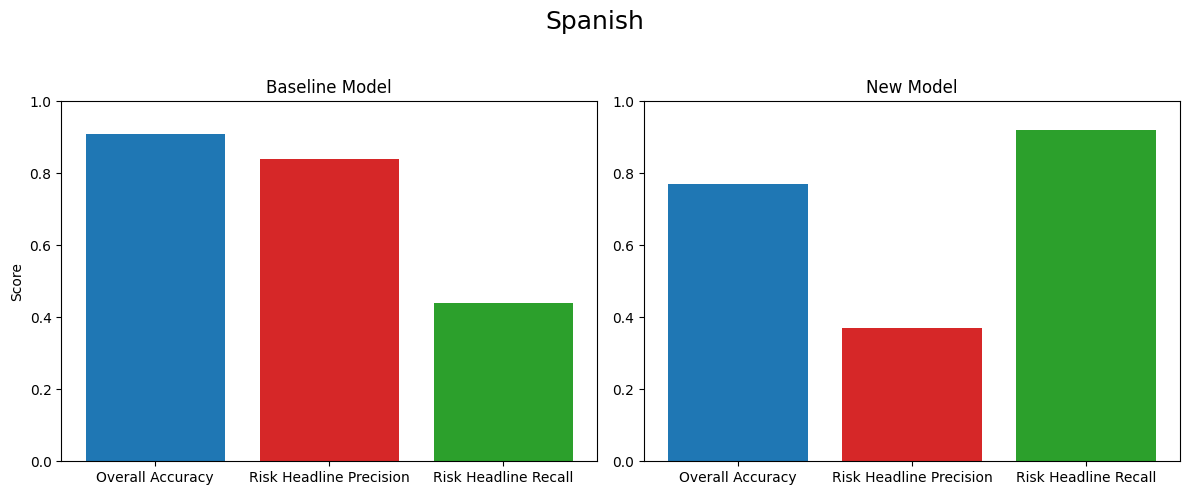

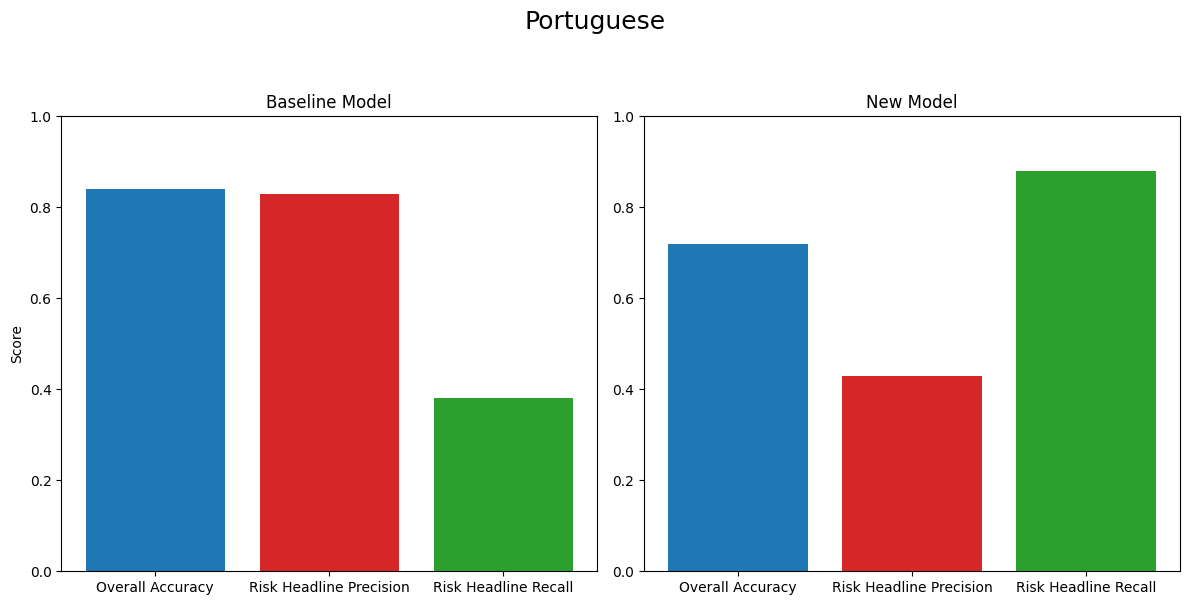

In [229]:
import matplotlib.pyplot as plt
import numpy as np

# data
base_model_spanish = [0.91, 0.84, 0.44]
base_model_portuguese = [0.84, 0.83, 0.38]
new_model_spanish = [0.77, 0.37, 0.92]
new_model_portuguese = [0.72, 0.43, 0.88]

# labels for the statistics
labels = ['Overall Accuracy', 'Risk Headline Precision', 'Risk Headline Recall']
colors = ['tab:blue', 'tab:red', 'tab:green']

# create subplots for Spanish
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# plot baseline model stats for Spanish
axs[0].bar(labels, base_model_spanish, color=colors)
axs[0].set_title('Baseline Model')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# plot new model stats for Spanish
axs[1].bar(labels, new_model_spanish, color=colors)
axs[1].set_title('New Model')
axs[1].set_ylim(0, 1)

# add overall title for Spanish
fig.suptitle('Spanish', fontsize=18)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_spanish_metrics.png', dpi=600, bbox_inches='tight')

# show the Spanish plot
plt.show()

# create subplots for Portuguese
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plot baseline model stats for Portuguese
axs[0].bar(labels, base_model_portuguese, color=colors)
axs[0].set_title('Baseline Model')
axs[0].set_ylim(0, 1)
axs[0].set_ylabel('Score')

# Plot new model stats for Portuguese
axs[1].bar(labels, new_model_portuguese, color=colors)
axs[1].set_title('New Model')
axs[1].set_ylim(0, 1)

# add overall title for Portuguese
fig.suptitle('Portuguese', fontsize=18, y=1)

# adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.95])

# save image
plt.savefig('../Images/improve_labels_portuguese_metrics.png', dpi=600, bbox_inches='tight')

# show the Portuguese plot
plt.show()

## Save dataframes

Finally, the refined dataframes are saved as CSV files for further use in additional notebooks.

In [ ]:
new_filtered_spanish_df.to_csv('../Data/spanish_df.csv', index=False)
new_filtered_portuguese_df.to_csv('../Data/portuguese_df.csv', index=False)